In [1]:
#First, make sure the notebook is aware of the workshop data sets
!pip install ase
!git clone https://github.com/icomse/5th_workshop_MachineLearning.git
import os
os.chdir('5th_workshop_MachineLearning/data')

fatal: destination path '5th_workshop_MachineLearning' already exists and is not an empty directory.


## Regression as machine learning

Let's start with the simplest models we can! Plain old fitting to a line; the simplest model there can be. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

In [3]:
# the names in sklearn tend to be pretty long, so we will import the individual
# objects rather than the whole library 

from sklearn.linear_model import LinearRegression

### Let's read in some data

This is some artificial data we will be playing around with to illustrate some important concepts.

In [4]:
dlin = pd.read_csv('linmod.csv')

What does this data look like? Inspect directly and plot.

In [5]:
dlin.head()

,inputs,outputs
0,8.894,16.107
1,8.691,16.509
2,11.080,16.941
3,16.344,17.382
4,13.662,17.831


In [ ]:
dlin.plot(x='inputs',y='outputs',kind='scatter')
plt.show()

Now, let's train a linear model with the data! First, create the model. It starts out as just an empty object, that we need to fill.

In [6]:
linmodel = LinearRegression()

Now look up the documentation as to what to do to fit the model. When you fit it, what do you get back? NOTE: `LinearRegression` expects that that the input X is a 2D arrray, of size `[n_features, n_samples]`, because it is designed to handle the general case that you are doing multiple variable linear regression. So if you pass in a 1D array, it will error. Read the error message you get carefully for a quick fix.

In [7]:
X = dlin['inputs'].values.reshape(-1, 1)
Y = dlin['outputs']
linmodel.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

OK, you have a model. We next want to plot the prediction of the model and the points on the same plot?

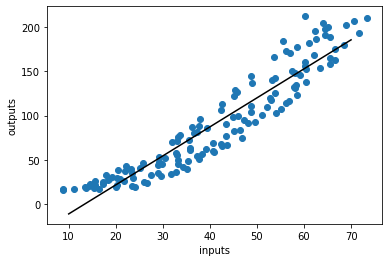

In [8]:
xvals = np.linspace(10,70,100)
ypred = linmodel.predict(xvals.reshape(-1,1))  # use this to apply the model
plt.plot(xvals,ypred,c='k')
plt.scatter(X,Y)
plt.xlabel('inputs')
plt.ylabel('outputs')
plt.show()

What methods does the `LinearRegression` have? What information can you get from it?  What are the parameters of a 1D linear regression?  What is a measure of how good the model is?

In [ ]:
linmodel?

In [9]:
print(linmodel.intercept_)
print(linmodel.coef_)
print(linmodel.score(X,Y))  # in this case, the score gives the R^2.

-43.99275057150068
[3.27921449]
0.8875612848546925


Let's play around with (over)fitting!  There's a little bit of curvature - in the data; maybe we should try a polynomial fit?

Let's actually just use a sample of the data set to train; we want to go up to the number of data points, and polynomial regression is numerically unstable with large numbers.  There are `sklearn` tools for doing this type of split.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

We make a polynomial fit using sklearn by taking powers of the input features.  `scikit-learn` has a function for this.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

To use it, you create a `PolynomialFeatures` object of the degree you are interested in, then take the powers of the data using the fit_transform method of `PolynomialFeatures`. See example (you will have to supply your own X, which is the same input as `LinearRegression.fit` takes.

In [13]:
pf = PolynomialFeatures(degree=2)
pX_train = pf.fit_transform(X_train)

In [14]:
print(X_train[:5])
print(pX_train[:5])

[[55.455]
 [48.728]
 [37.339]
 [42.484]
 [21.745]]
[[1.00000000e+00 5.54550000e+01 3.07525702e+03]
 [1.00000000e+00 4.87280000e+01 2.37441798e+03]
 [1.00000000e+00 3.73390000e+01 1.39420092e+03]
 [1.00000000e+00 4.24840000e+01 1.80489026e+03]
 [1.00000000e+00 2.17450000e+01 4.72845025e+02]]


it's a degree $\times$ n_data array; with each column the input data to power $n$.

Now, lets see how the model fits the data.  Inspect the model parameters and the $R^2$, and plot the fit and the curve.

In [15]:
linmodel.fit(pX_train,Y_train)
print(linmodel.intercept_)
print(linmodel.coef_)
print('R^2 (train) =', linmodel.score(pX_train,Y_train))

3.3904071326561223
[0.         0.647008   0.03140732]
R^2 (train) = 0.9151857345242682


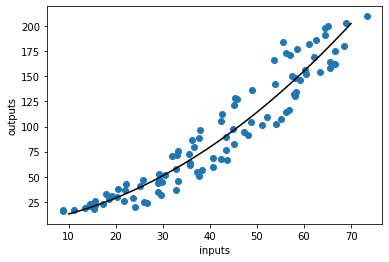

In [16]:
xvals = np.linspace(10,70,100)
px = pf.fit_transform(xvals.reshape(-1,1))
ypredict = linmodel.predict(px)
plt.plot(xvals,ypredict,c='k')
plt.scatter(X_train,Y_train)
plt.xlabel('inputs')
plt.ylabel('outputs')
plt.show()

Now test the model on the test set.

R^2 = 0.9092489189185435


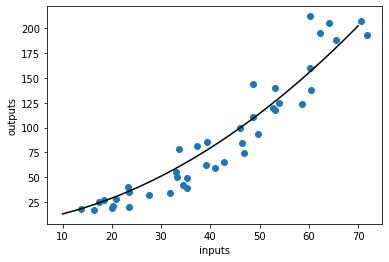

In [20]:
pX = pf.transform(X_test) # create polynomial features.
plt.plot(xvals,ypredict,c='k')
plt.scatter(X_test,Y_test)
plt.xlabel('inputs')
plt.ylabel('outputs')
print('R^2 =', linmodel.score(pX,Y_test))

Remember, it's the TESTING MSE (or $R^2$) that we want to minimize, not the training MSE.  If the training MSE is low, but the testing is high, then the model is overfit.  

**HACKING TIME**: Now, go back and try a higher polynomial degree. Note that polynomial fitting is not very numerically stable, so if you fit to too many points, then you start to have problems.  What problems do you have?

Can you plot $R^2$ (i.e. linmodel.score) for the test and training set versus polynomial degree?  What do you see?

**An Answer**:

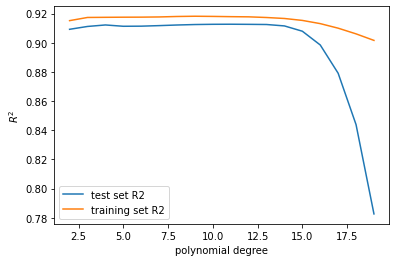

In [26]:
R2test = list()
R2train = list()
ps = list()
for p in range(2,20):
    pf = PolynomialFeatures(degree=p)
    pX_train = pf.fit_transform(X_train)
    linmodel.fit(pX_train,Y_train)
    R2train.append(linmodel.score(pX_train,Y_train))
    pxvals = pf.fit_transform(xvals.reshape(-1,1)) # generate the polynomial input data
    ypredict = linmodel.predict(pxvals)
    pX_test = pf.fit_transform(X_test)
    R2test.append(linmodel.score(pX_test,Y_test))
    ps.append(p)
    
plt.plot(ps,R2test,label='test set R2')
plt.plot(ps,R2train,label='training set R2')
plt.xlabel('polynomial degree')
plt.ylabel('$R^2$')
plt.legend()
plt.show()

Generally the training set will get a bit better as the model gets more complex, whereas the test model gets worse as the trained model starts to overfit.

### Multilinear regression

That's well and good, but that is just one input.  Usually, we have LOTS of features and want to use all of them.

In [29]:
cld=pd.read_csv('HCEPDB_100K_cleaned.csv') # change where it is
# (but first you might refresh yourself on what is contained
# we'll use a smaller sample to make it go faster, and to make the problem a bit harder.
cld = cld[cld['pce']!=0] # clean out the data where PCE = 0 (data not obtained)
cld_sample = cld.sample(n=1000,random_state=12345)

The basic principle (and code!) is the same as ordinary least squares.

In [30]:
features = ['mass', 'voc', 'jsc', 'e_homo_alpha', 'e_gap_alpha', 'e_lumo_alpha']
observable = 'pce'
X = cld_sample[features]
Y = cld_sample[observable]

In [31]:
# now fit the model
linmodel = LinearRegression() 
linmodel.fit(X,Y)
linmodel.score(X,Y)

0.8862756763863607

Now, there are more coefficients! One for each feature

In [32]:
linmodel.coef_

array([ 1.17614680e-03,  1.12593317e+00, -1.92358868e-02, -1.12593317e+00,
       -3.91971440e+00, -5.04564757e+00])

One think to take into account, though. What if the data has different units, or is different types?  How will the coefficients change? 


### General linear models 

The extension from multiple linear regression to general additive models is straightforward; it uses the same module `LinearRegression` module.

Let's first look at the residuals, versus the model output, and then the residuals versus each of the variables, and see if there is any nonlinearity. Check the RSE of this model for future reference.

In [38]:
from sklearn.metrics import mean_squared_error

In [84]:
train,test = train_test_split(cld, test_size=0.95)
features = ['mass', 'voc', 'e_lumo_alpha']
observable = 'pce'
train_X = train[features]
train_Y = train[['pce']]
test_X = test[features]
test_Y = test[['pce']]

In [85]:
model = LinearRegression() 
model.fit(train_X,train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

RSE = 0.5402714730452292


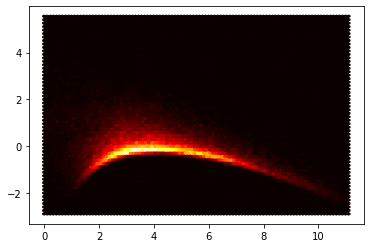

In [86]:
print("RSE =",mean_squared_error(test_Y,model.predict(test_X)))
plt.hexbin(test_Y,model.predict(test_X)-test_Y,cmap='hot')
plt.show()

Let's look at the residuals as a function of the input data to try to understand what values of the inputs have more error. 

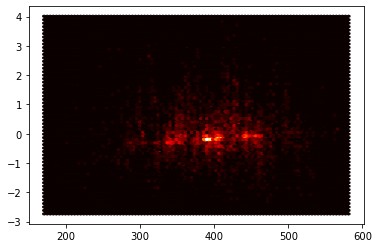

In [87]:
plt.hexbin(train_X[['mass']],model.predict(train_X)-train_Y,cmap='hot')
plt.show()

There doesn't really appear to be that much bias in the prediciotns with respect to mass, the errors are all symmetric.  Let's try the other data.

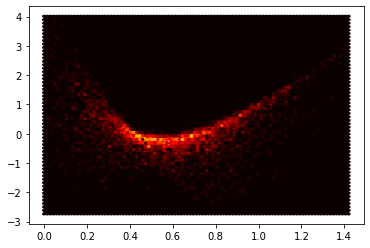

In [88]:
plt.hexbin(train_X[['voc']],model.predict(train_X)-train_Y,cmap='hot')
plt.show()

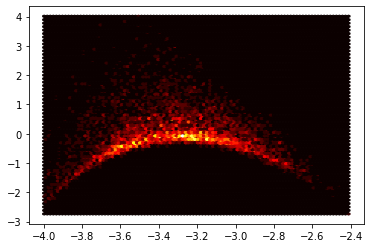

In [89]:
plt.hexbin(train[['e_lumo_alpha']],model.predict(train_X)-train_Y,cmap='hot')
plt.show()

What sort of nonlinear model do these plots suggest to try?  Try something, and compare $R^2$, RSE, and plot the residuals of the new model and the new model.  There's sort of a curve to the residual plot, so maybe add polynomial terms.

In [93]:
# for complicated reasons, we have to add columns to the origina dataframe , not the cleaned dataframe 
# (basically, since the cleaned file is a slice of a dataframe, not a dataframe itself)
cld['voc2'] = cld['voc']**2  
cld['lumo2'] = cld['e_lumo_alpha']**2
cld['voc3'] = cld['voc']**3
cld['lumo3'] = cld['e_lumo_alpha']**3
cld = cld[cld['pce']!=0]  # clean out bad PCE's again. 

RSE = 0.12976019361124194


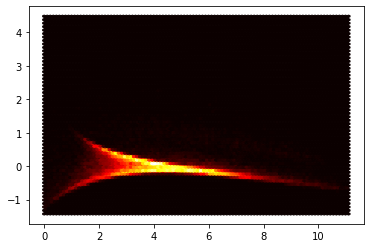

In [94]:
train,test = train_test_split(cld, test_size=0.95)
features = ['mass','voc','voc2','voc3','e_lumo_alpha','lumo2','lumo3']
observable = 'pce'
train_X = train[features]
train_Y = train[['pce']]
test_X = test[features]
test_Y = test[['pce']]

model = LinearRegression() 
model.fit(train_X,train_Y)

print("RSE =",mean_squared_error(test_Y,model.predict(test_X)))
plt.hexbin(test_Y,model.predict(test_X)-test_Y,cmap='hot')
plt.show()

**Hacking time!**: What other general linear models, more complicated or simpler, can you test? How do you know if they are better?

**An answer** -  there are lots of functions we could add; logarithms, reciprocals.  Let's try adding just cross terms, i.e. that multiply two variables together. 

In [95]:
cld['lumo_voc'] = cld['e_lumo_alpha']*cld['voc']
cld = cld[cld['pce']!=0]  # clean out bad PCE's again. 

RSE = 0.028933823699614964


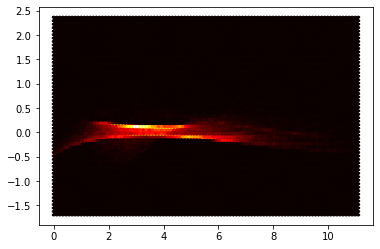

In [81]:
train,test = train_test_split(cld, test_size=0.95)
features = ['mass','voc','voc2','voc3','e_lumo_alpha','lumo2','lumo3',"lumo_voc"]
observable = 'pce'
train_X = train[features]
train_Y = train[['pce']]
test_X = test[features]
test_Y = test[['pce']]

model = LinearRegression() 
model.fit(train_X,train_Y)

print("RSE =",mean_squared_error(test_Y,model.predict(test_X)))
plt.hexbin(test_Y,model.predict(test_X)-test_Y,cmap='hot')
plt.show()

Yep, that crossterm reduces the MSE quite a bit!

## Regularization

Let's go back to the linear features.

In [116]:
features = ['mass', 'voc', 'jsc', 'e_homo_alpha', 'e_gap_alpha', 'e_lumo_alpha']

LASSO can take some time due to the issues in minimizing with the absolute value terms, so we will run on less data.  Also, the trends in this data set are very clear, so we need to choose relatively little data to have the algorithm overfit.

In [145]:
cld_sample = cld.sample(n=1000,random_state=321)

Now make a test-train split. We'll reserve most of the data for testing (we want to make it harder to fit!)

In [211]:
train, test = train_test_split(cld_sample, test_size=0.95, random_state=321)

Unline linear regression, units matter with regularized fitting, because the coefficient term has units that don't cancel out with the coefficiencts.  We use data standardization or normalization to remove this effect.  Now, it's not always the best thing to do.  If you have two variables that are the same units, it could be that the relative sizes DO matter. However, generally standarization helps, and at minimum, it makes sure that the model does not depend on the units used.

In [212]:
from sklearn.preprocessing import StandardScaler

In [245]:
scaler = StandardScaler()
scaler.fit(train[features])   # fit to just the training data, so we don't have data leakage
train_standardized = pd.DataFrame(data=scaler.transform(train[features]),columns=features)
test_standardized = pd.DataFrame(data=scaler.transform(test[features]),columns=features)
# stick back in the unscaled observables
test_standardized['pce']=test['pce'].values 
train_standardized['pce']=train['pce'].values

For lasso and ridge regression, $R^2$ doesn't quite make sense, because the extra terms messes with calculation of the total sum of squares.  Instead, let's just look at the means squared error. For simple linear regression (no matter how many v
ariables.  Also, the coefficients of simple linear regression can take into account the change of units (it's the shrinkage term that causes problems), but we'll do everything with standardized data to make it simpler. 

## Part 1: Just getting it set up with more rigor: Multiple linear regression

Train error 0.6318197496970686
Test error 0.8815985035688619
MLR coeffs = [[ 2.40510743e-02 -3.46840499e+14 -1.56250000e+00 -5.84117782e+13
   4.48481252e+14 -3.37421728e+14]]


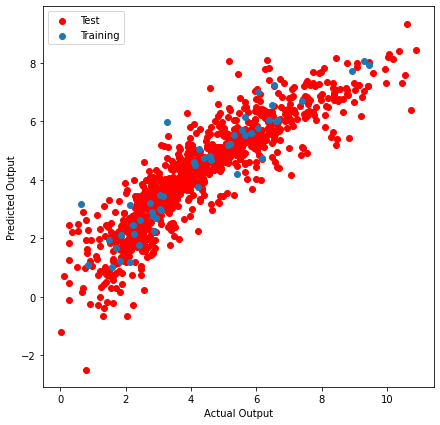

In [215]:
# train linear model 
MLR=LinearRegression()
MLR.fit(train_standardized[features],train_standardized[[observable]])

# make predictions on test and train set 
trainpred=MLR.predict(train_standardized[features])
testpred=MLR.predict(test_standardized[features])

#make parity plot 
plt.figure(figsize=(7,7))
plt.scatter(test[observable],testpred,color='r', label='Test')
plt.scatter(train[observable],trainpred, label='Training')
plt.plot(lw=4,color='black')
plt.legend()
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')

#calculate the test and train error
print("Train error",mean_squared_error(train_standardized[observable],trainpred))
print("Test error",mean_squared_error(test_standardized[observable],testpred))
print("MLR coeffs =", MLR.coef_)

## Part 2: Ridge Regression (same data as Part 1)

* The ridge coefficients minimize $RSS + \lambda \sum_{j=1}^{p}\beta_j^2$
* There is an additional **penalty** in error for having large coefficients!
* Note: ISLR shows the tuning parameter as $\lambda$, but it is $\alpha$ in `sk-learn`
* Goal here: train models as a function of the regularization parameter 
* The X's **must** be be standardized for ridge regression to work correctly 
* Some methods in `sk_learn` also do automatic selection of shrinkage coefficient - you can try those out afterwards. 
* **For the next section, I suggest on your own you test out what normalization in ridge does, by executing the following code first WITHOUT and then WITH normalization** 

In [216]:
from sklearn.linear_model import Ridge, Lasso

### Example of a single instance of ridge regression


In [217]:
ridge=Ridge()
a=2.0
ridge.set_params(alpha=a)
ridge.fit(train_standardized[features],train_standardized[observable])

Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [218]:
train_predict = ridge.predict(train_standardized[features])
test_predict = ridge.predict(test_standardized[features])
print(mean_squared_error(train_standardized[observable],train_predict))
print(mean_squared_error(test_standardized[observable],test_predict))
print(ridge.coef_)

1.0365271282794941
0.5716190693059116
[ 0.16653362  0.29924167 -1.08208763 -0.29924167 -1.0183595  -1.6093363 ]


In [219]:
ridge=Ridge()
a=8.0
ridge.set_params(alpha=a)
ridge.fit(train_standardized[features],train_standardized[observable])
train_predict = ridge.predict(train_standardized[features])
test_predict = ridge.predict(test_standardized[features])
print(mean_squared_error(train_standardized[observable],train_predict))
print(mean_squared_error(test_standardized[observable],test_predict))
print("MLR coeffs =", ridge.coef_)

1.2566977155501038
0.6984830548878866
MLR coeffs = [ 0.24183732  0.416851   -0.18130023 -0.416851   -0.57843119 -1.12514196]


### Hyperparameters

$\alpha$ (or $\lambda$) is an example of a *hyperparameter*.  It's a variable that will change exactly what the model is doing.  The parameters of the models are the coefficients of the ridge regression; each choice of parameter gives a different model, but each choice of hyperparameters leads to a different model. Deep learning methods often have *many* hyperparameters. Tuning hyperparameters is a key part of building machine learning models.  So let's tune a hyperparameter!

**Hacking**: 
1. Redo the linear regression with standardized data.  How do the coefficents change when you add regression?
2. Vary $\alpha$ and see how the predictions and coefficients change.

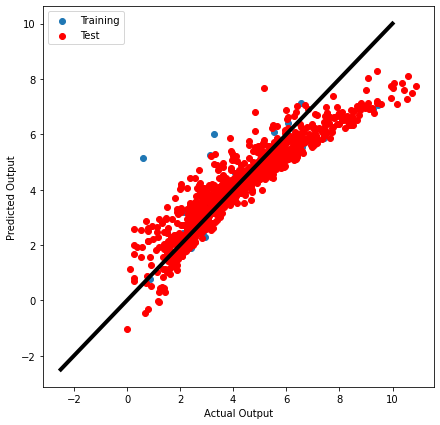

In [220]:
plt.figure(figsize=(7,7))
plt.scatter(train_standardized[observable],train_predict, label='Training')
plt.scatter(test_standardized[observable],test_predict,color='r', label='Test')
plt.plot([-2.5,10],[-2.5,10],lw=4,color='black')
plt.legend()
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')
plt.show()

### Example of searching the $\alpha$ ($\lambda$ in the slides) space in ridge regression

In [221]:
# RR vs lambda (based on sklearn tutorial)
coefs = []
trainerror = []
testerror = []

model = Ridge()

lambdas = np.logspace(-4,5,100)
# loop over lambda values (strength of regularization and find the errors)
for l in lambdas:
    model.set_params(alpha=l)
    model.fit(train_standardized[features],train_standardized[observable])
    coefs.append(model.coef_)
    trainerror.append(mean_squared_error(train_standardized[observable],model.predict(
        train_standardized[features])))
    testerror.append(mean_squared_error(test_standardized[observable],model.predict(
        test_standardized[features])))

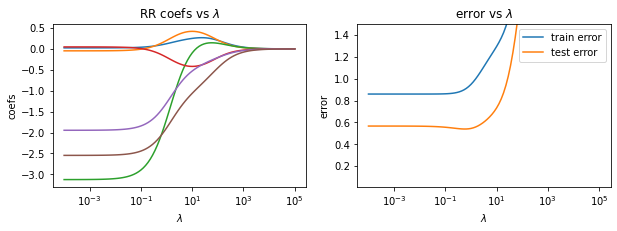

In [222]:
# what is being plotted here? 
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(lambdas,coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('coefs')
plt.title('RR coefs vs $\lambda$')
plt.subplot(122)
plt.plot(lambdas,trainerror,label='train error')
plt.plot(lambdas,testerror,label='test error')
plt.xscale('log')
plt.ylim([0.01,1.5])
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.legend(loc=1)
plt.title('error vs $\lambda$')
plt.show()

**Pause and discuss with a partner**: What is happening in these plots? 

The model is best (least overfit, best test MSE) at between $\lambda$ value:

In [224]:
lambdas[np.argmin(testerror)] #the lambda where the MSE is minimized

0.5336699231206312

## Part 3: LASSO regression  (same data as Part 1)

* The LASSO improves over ridge regression by also providing a variable selection tool!
* The LASSO minimizer is $RSS + \lambda \sum_{j=1}^{p}\lvert\beta_j\rvert$

**Hacking time**: Plot the LASSO regression coefficients versus the magnitude of the shrinkage term, in the same way the ridge regression was done above.

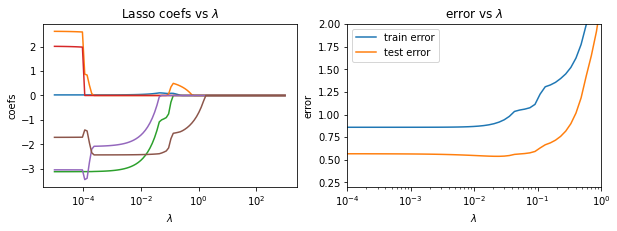

In [225]:
# also based on sklearn tutorials
# think about what is happening in this cell?
coefs = []
trainerror = []
testerror = []
lambdas = np.logspace(-5,3,100)
model = Lasso() # we already standardized the data

# loop over lambda values (strength of regularization)
for l in lambdas:
    model.set_params(alpha=l,max_iter=100000)
    model.fit(train_standardized[features],train_standardized[observable])
    coefs.append(model.coef_)
    trainerror.append(mean_squared_error(train_standardized[observable],model.predict(
        train_standardized[features])))
    testerror.append(mean_squared_error(test_standardized[observable],model.predict(
        test_standardized[features])))

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(lambdas,coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('coefs')
plt.title('Lasso coefs vs $\lambda$')

plt.subplot(122)
plt.plot(lambdas,trainerror,label='train error')
plt.plot(lambdas,testerror,label='test error')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.xlim(1e-4,1e0)
plt.ylim(0.2,2.0)
plt.legend()
plt.title('error vs $\lambda$')
plt.show()

In [226]:
min_lambda = lambdas[np.argmin(testerror)]  
print(min_lambda)

0.024770763559917114


In [227]:
coefs[np.argmin(testerror)]

array([ 0.07147774, -0.        , -1.95804615,  0.        , -0.92605294,
       -2.40868359])

In [228]:
coefs[np.argmin(testerror)]==0.0

array([False,  True, False,  True, False, False])

Some of the coefficients are zero. Specifically:

In [229]:
np.array(features)[coefs[np.argmin(testerror)]==0.0]  # need to convert to numpy array to use masking. 

array(['voc', 'e_homo_alpha'], dtype='<U12')

So LASSO suggest that the best model would have just:

In [230]:
np.array(features)[coefs[np.argmin(testerror)]!=0.0] 

array(['mass', 'jsc', 'e_gap_alpha', 'e_lumo_alpha'], dtype='<U12')

## Classification using logistic regression

Let's use a database of perovskite stability data patients to demonstrate logistic regression.  Perovskites have the general formula $ABX_3$, where $A$ and $B$ are cations and $X$ is an anion.

The variables are described as follows:
- ABX3: chemical formula of the compound
- exp_label: is it stable?  -1 is no, 1 is yes
- is_train: is it training data? -1 is no, 1 is yes
- nA: $n_A$, oxiation state of A
- nB: $n_B$, oxidation state of B
- nX: $n_X$, oxidation state of X
- rA (Ang):	$r_A$, ionic radius of A in Angstroms
- rB (Ang):	$r_B$, ionic radius of B in Angstroms
- rX (Ang):	$r_X$, ionic radius of X in Angstroms
- t: $t$, Goldschmidt tolerance factor, $\frac{r_A + r_X}{\sqrt{2}\left(r_B+r_X\right)}$
- tau: $\tau$, Bartel et al. tolerance factor $\frac{r_X}{r_B}-n_A\left(n_A - \frac{r_A/r_B}{\ln(r_A/r_B)}\right)$
- t_pred: Whether $t$ predicts it will be a perovskite, -1 is no, 1 is yes
- tau_pred:	Whether $\tau$ predicts it will be a perovskite ($\tau < 4.18$), -1 is no, 1 is yes
- tau_prob:	Probability that the compund it is a perovskite, according to $\tau$	

nA, nB, nX, rA, rB, rX are the features used for training.

Let's start by just looking at the means and standard deviations to see what it looks like.

In [231]:
perov=pd.read_csv('perovskite_data.csv')
perov.head()

,ABX3,exp_label,is_train,A,B,X,nA,nB,nX,rA (Ang),rB (Ang),rX (Ang),t,tau,t_pred,tau_pred,tau_prob
0,AgBrO3,-1.0,1,Ag,Br,O,1,5,-2,1.28,0.31,1.40,1.11,6.43,-1,-1,0.05
1,AgCdBr3,-1.0,1,Ag,Cd,Br,1,2,-1,1.28,0.95,1.96,0.79,5.58,-1,-1,0.12
2,PbAgBr3,-1.0,1,Pb,Ag,Br,2,1,-1,1.49,1.15,1.96,0.78,7.71,-1,-1,0.01
3,AgCaCl3,-1.0,1,Ag,Ca,Cl,1,2,-1,1.28,1.00,1.81,0.78,6.00,-1,-1,0.07
4,AgClO3,-1.0,1,Ag,Cl,O,1,5,-2,1.28,0.12,1.40,1.25,15.17,-1,-1,0.00


In [232]:
# examine the input features which are not categorical. 
training_features = ['nA','nB','nX','rA (Ang)','rB (Ang)', 'rX (Ang)']
perov[training_features].describe()


,nA,nB,nX,rA (Ang),rB (Ang),rX (Ang)
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,1.930556,2.991319,-1.640625,1.357969,0.700330,1.528490
std,0.909106,1.078612,0.480234,0.318998,0.231042,0.259552
min,1.000000,1.000000,-2.000000,0.540000,0.120000,1.330000
25%,1.000000,2.000000,-2.000000,1.110000,0.600000,1.400000
50%,2.000000,3.000000,-2.000000,1.360000,0.690000,1.400000
75%,3.000000,4.000000,-1.000000,1.640000,0.800000,1.400000
max,5.000000,5.000000,-1.000000,1.880000,1.350000,2.200000


Let's inspect the other data to make sure we know what is going on.

<AxesSubplot:>

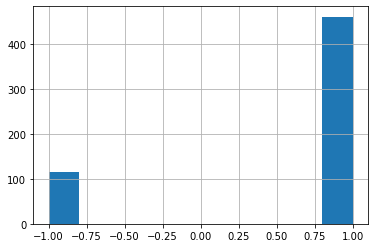

In [233]:
perov['is_train'].hist()

`LogisticRegression` is in `sklearn.linear_model` and has many of the same inputs and outputs as `LinearRegression`

In [234]:
from sklearn.linear_model import LogisticRegression

Train a `LogisticRegression` model on the six inputs, and score it. (What is the score here? is it $R^2$)?

In [235]:
perov_training = perov[perov['is_train']==1]
perov_testing =  perov[perov['is_train']==-1]
inputData = perov_training[['nA','nB','nX','rA (Ang)','rB (Ang)', 'rX (Ang)']]
outputData = (perov_training['exp_label']+1)/2  # rescale to 0,1, though it ends up not mattering.

inputData_test = perov_testing[['nA','nB','nX','rA (Ang)','rB (Ang)', 'rX (Ang)']]
outputData_test = (perov_testing['exp_label']+1)/2  # rescale to 0,1, though it ends up not mattering.

In [236]:
logit1=LogisticRegression(solver='liblinear')
#we specify the liblinear solver to avoid a warning about not specifying
logit1.fit(inputData,outputData)
logit1.score(inputData,outputData)

0.7913043478260869

`Score` for logistic regression is just the fraction that are right.

In [237]:
np.mean(logit1.predict(inputData)==outputData)

0.7913043478260869

Now, check on the test data.

In [238]:
logit1.score(inputData_test,outputData_test)

0.8189655172413793

If we were to use NO inputs, just the outputs, we would predict that the percent that are stable would be the same as the percent in our population, or about 50/50

In [239]:
np.mean(outputData)

0.5260869565217391

So we are getting noticably better than random!

Let's look at the documentation for the function.

In [240]:
LogisticRegression?

#### Model performance
What are the percent who are correctly classified by this model?  What are the true positive, true negative, false positive, and false negative?  Try using the `confusion_matrix` function of `sklearn.metrics`. How well does the model predict which women don't have diabetes?  How well does it predict which women do?

In [241]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(logit1.predict(inputData),outputData)
print(cm)

[[156  34]
 [ 62 208]]


In [242]:
confusion_matrix?

The format is: 
[[ True Negative  False Negative],
 [ False Positive True Positive]]

Look at coefficients.  Can you tell which ones are most important in predicting stability?  Why or why not? 

In [243]:
logit1.coef_

array([[ 1.03704601, -0.19385937, -0.28106221,  2.48363182,  2.34765653,
        -3.76687965]])

**Hacking Time:** How does a prediction with standardized variables do versus one without standardized ones? What do the coeficients look like before and after using standardized data?

Is all of the data linearly independent? (think about charges)


What are those other columns doing there?  What is `tau_pred`?  How was $\tau$ generated? Why is it doing better? Read up on [the paper it was defined in](https://www.science.org/doi/full/10.1126/sciadv.aav0693).

In [244]:
cm = confusion_matrix((perov_training['tau_pred']+1)/2,outputData)
print(cm)
cm = confusion_matrix((perov_testing['tau_pred']+1)/2,outputData_test)
print(cm)

[[195  18]
 [ 23 224]]
[[40  2]
 [ 5 69]]


In [209]:
np.mean((perov_training['tau_pred']+1)/2==outputData)

0.9108695652173913

In [210]:
np.mean((perov_testing['tau_pred']+1)/2==outputData_test)

0.9396551724137931